In [1]:
!pip install pandas statsmodels scikit-learn


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Импортируем зависимости 

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
from os.path import join as path_join
import os
import datetime

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning

warnings.simplefilter('ignore', category=ValueWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=RuntimeWarning)

In [3]:
power_statistic_dir = path_join(os.getcwd(), "power_consumption_statistics")
classroom_schedule = path_join(os.getcwd(), "classroom_schedule")

In [4]:
counters_to_rooms = {
"4101468": "371",
"4101472": "365",
"4101473": "361",
"4101471": "369",
"4101467": "381",
"4089401": "375"
}


In [5]:
power_df = pd.read_csv(path_join(power_statistic_dir, "power_25.02.2023.csv"), sep=";")

In [6]:
counter_id = "4101468"
data_colum_name = "total"
print("Find counters:", power_df.counter.unique().tolist())
print("Selected counter", counter_id, "located in room", counters_to_rooms.get(counter_id))

Find counters: [4101474, 4101473, 4101468, 4101467, 4101469, 4101471, 4089401, 4101472]
Selected counter 4101468 located in room 371


In [7]:
power_df = power_df.query(f"counter == {counter_id}")
power_df.datetime = pd.to_datetime(power_df.datetime, format="%Y-%m-%d %H:%M:%S")
power_df.sort_values(by='datetime', ascending = True, inplace = True)
power_df.set_index(["datetime"])
power_df_sample = power_df.loc[(power_df.datetime>=datetime.datetime(year=2022, month=12, day=1, hour=0)) & (power_df.datetime<=datetime.datetime(year=2023, month=2, day=2, hour=0))]
# power_df_sample = power_df


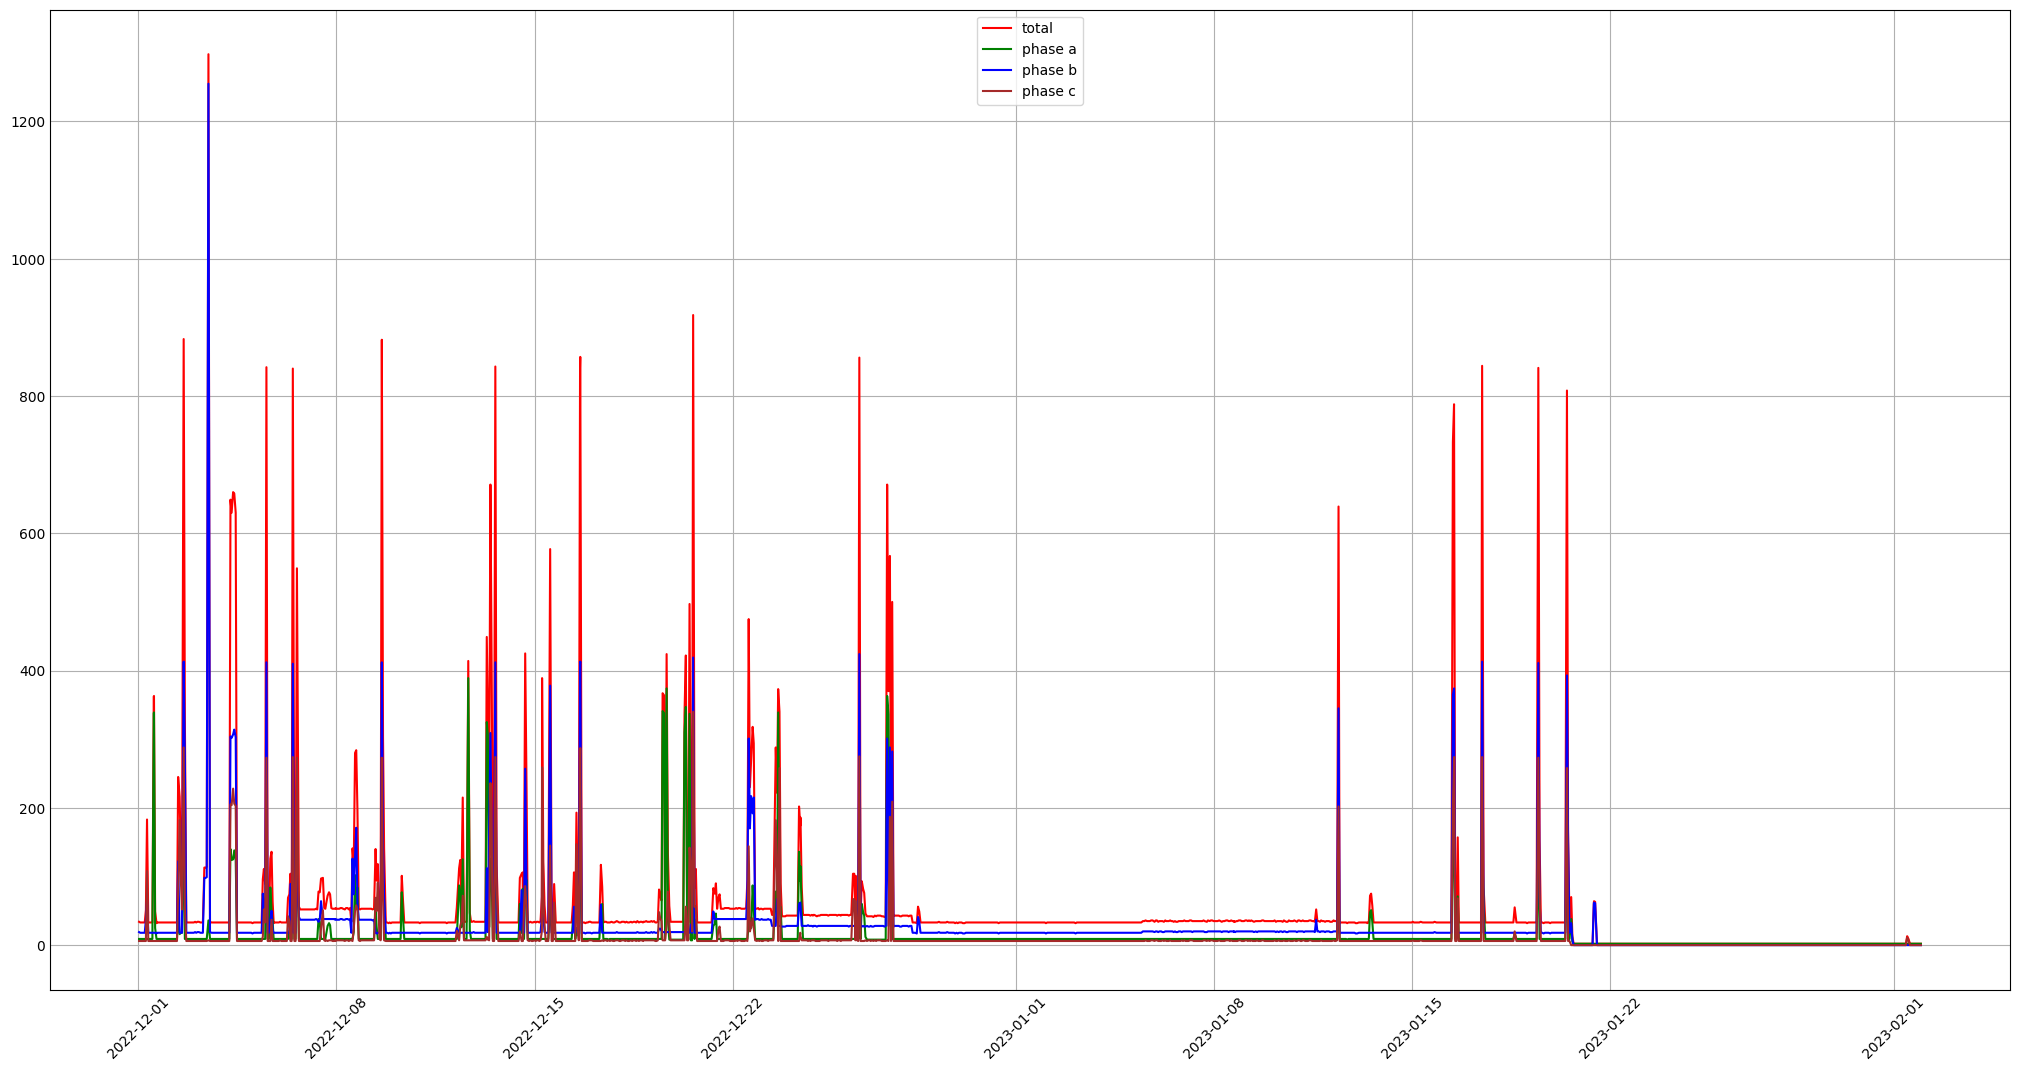

In [8]:
# length = 1000
def show_sample(power_df_sample, datetime_is_index: bool = True):
    x = list(power_df_sample.datetime) if not datetime_is_index else list(power_df_sample.index)

    plt.style.use('_mpl-gallery')
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 10)
    fig.set_dpi(100)


    y = list(power_df_sample.total)
    ax.plot(x, y, linewidth=1.5, color='red', label="total")

    y = list(power_df_sample.phase_a)
    ax.plot(x, y, linewidth=1.5, color='green', label="phase a")

    y = list(power_df_sample.phase_b)
    ax.plot(x, y, linewidth=1.5, color='blue', label="phase b")

    y = list(power_df_sample.phase_c)
    ax.plot(x, y, linewidth=1.5, color='brown', label="phase c")

    plt.legend(loc='upper center')
    plt.xticks(rotation=45)

    plt.show()

show_sample(power_df_sample, False)

In [9]:
from_datetime = datetime.datetime(year=2022, month=10, day=1, hour=0)
separation_datetime = datetime.datetime(year=2022, month=12, day=20, hour=0)
to_datetime = datetime.datetime(year=2022, month=12, day=25, hour=0)
train_df = power_df.loc[(power_df.datetime>=from_datetime) & (power_df.datetime<=separation_datetime)]
test_df = power_df.loc[(power_df.datetime>separation_datetime) & (power_df.datetime <= to_datetime)]
train_df

,datetime,counter,phase_a,phase_b,phase_c,total
32473,2022-10-01 00:18:06,4101468,9.0,10.0,7.0,26.0
32468,2022-10-01 00:18:06,4101468,9.0,10.0,7.0,26.0
32482,2022-10-01 01:31:44,4101468,9.0,10.0,7.0,26.0
32486,2022-10-01 01:31:44,4101468,9.0,10.0,7.0,26.0
32496,2022-10-01 02:25:43,4101468,9.0,10.0,6.0,25.0
...,...,...,...,...,...,...
18628,2022-12-19 21:27:10,4101468,8.0,19.0,7.0,34.0
18643,2022-12-19 22:43:53,4101468,8.0,19.0,7.0,34.0
18649,2022-12-19 22:43:53,4101468,8.0,19.0,7.0,34.0
18656,2022-12-19 23:42:12,4101468,8.0,19.0,7.0,34.0


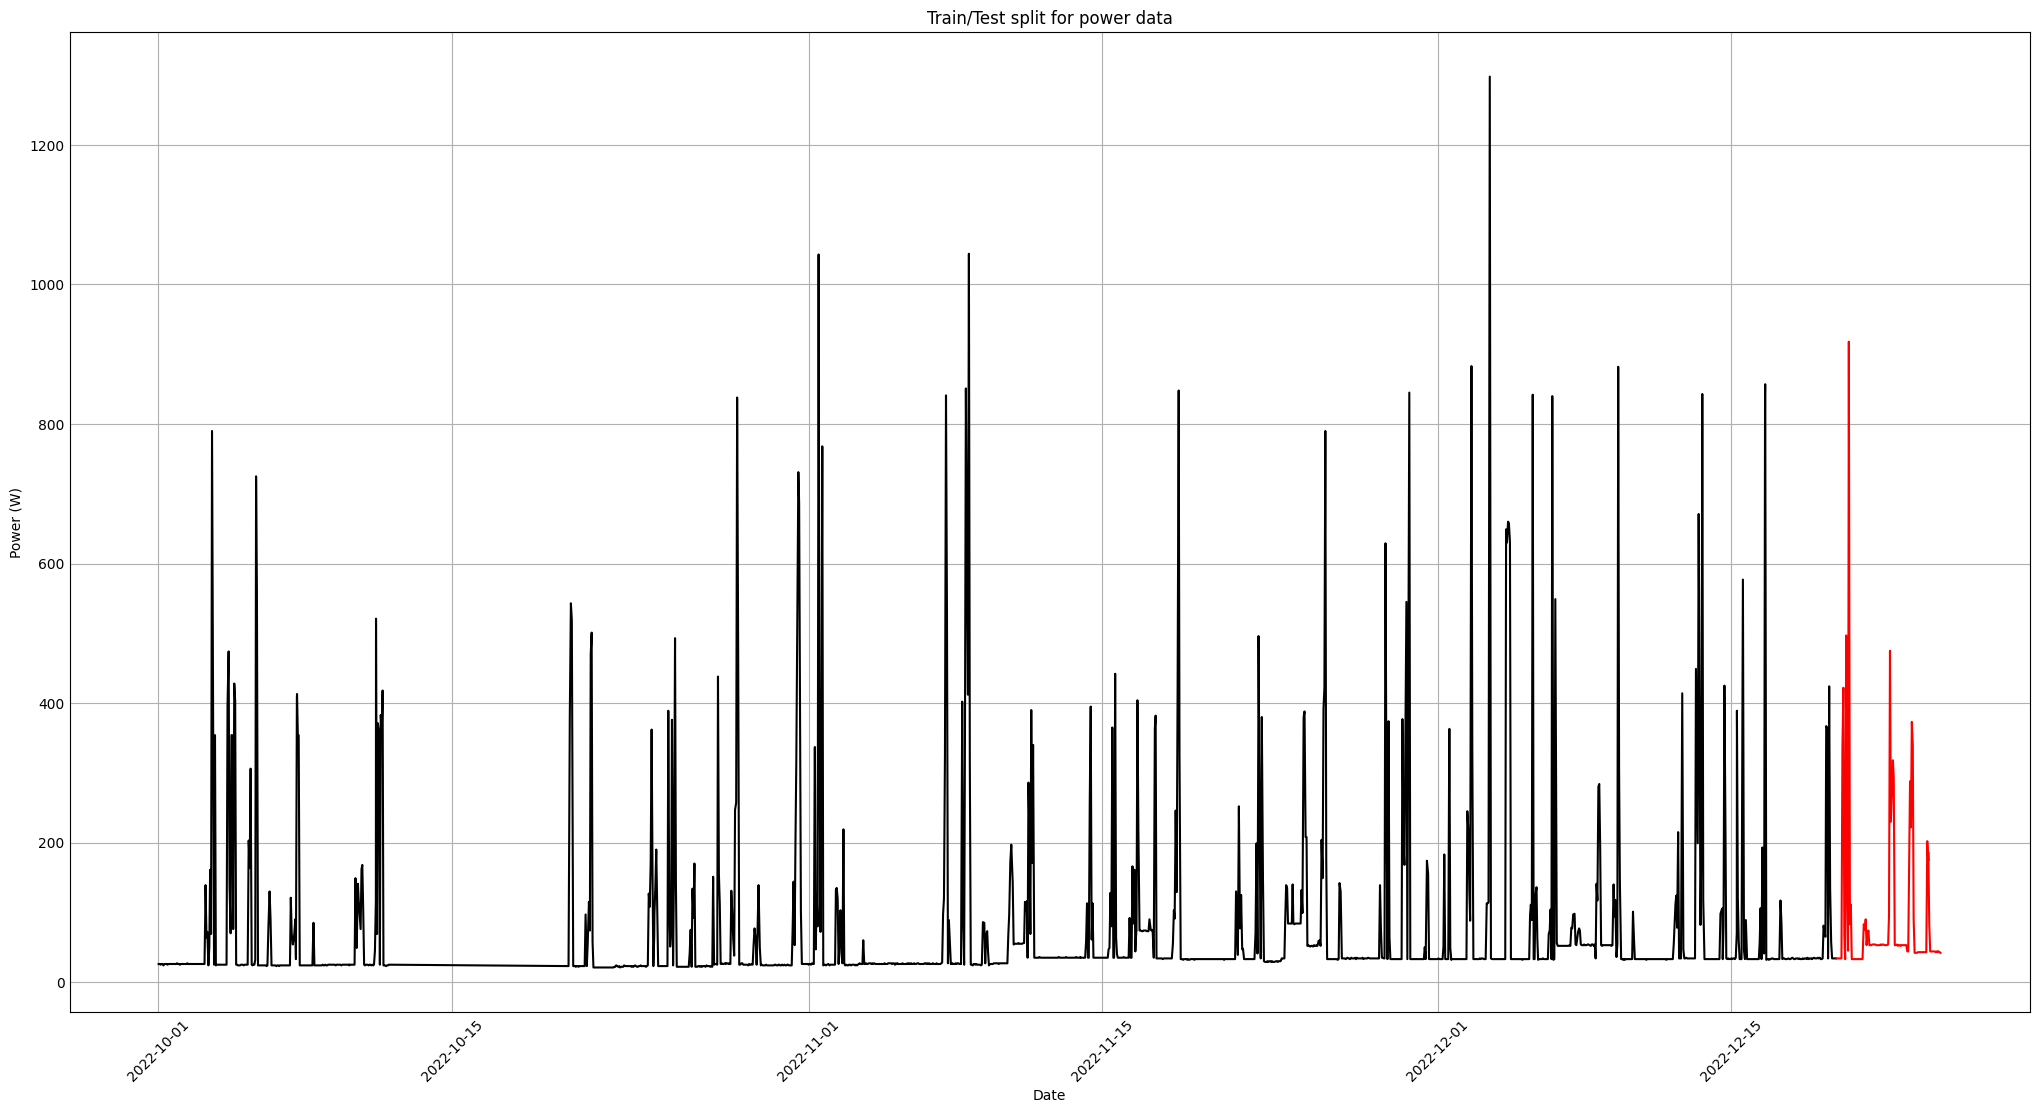

In [10]:
train_x = list(train_df.datetime)
test_x = list(test_df.datetime)

plt.style.use('_mpl-gallery')
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
fig.set_dpi(100)

plt.plot(train_x, train_df[data_colum_name], color = "black", label = "train")
plt.plot(test_x, test_df[data_colum_name], color = "red", label = "test")
plt.ylabel('Power (W)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for power data")
plt.show()

Подберем модель

In [11]:
def find_best_model(model, test_df):
    y = test_df[data_colum_name]

    best_model = (0, 0, 0)
    best_rmse = 1_000_000

    value1, value2, value3 = 0, 0, 0
    max_value = 5

    for v1 in range(max_value+1):
        for v2 in range(max_value+1):
            for v3 in range(max_value+1):
                ARMAmodel = model(y, order = (v1, v2, v3))
                try:
                    ARMAmodel = ARMAmodel.fit()
                except:
                    print("Error! Continue")
                    continue

                y_pred = ARMAmodel.get_forecast(len(test_df.index))
                y_pred_df = y_pred.conf_int(alpha = 0.05) 
                y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
                y_pred_df.index = test_df["datetime"]
                y_pred_out = y_pred_df["Predictions"]
                try:
                    arma_rmse = np.sqrt(mean_squared_error(test_df[data_colum_name].values, y_pred_df["Predictions"]))
                except:
                    print("blah")
                    continue
                if arma_rmse < best_rmse:
                    print((v1, v2, v3), "is better than", best_model, "|", best_rmse, "->", arma_rmse)
                    best_model = (v1, v2, v3)
                    best_rmse = arma_rmse
    return best_model,best_rmse


In [12]:

arma_best_model, best_rmse = find_best_model(SARIMAX, test_df)
print(arma_best_model, best_rmse)

(0, 0, 0) is better than (0, 0, 0) | 1000000 -> 155.6307156150647
(0, 0, 1) is better than (0, 0, 0) | 155.6307156150647 -> 155.61624403156293
(0, 0, 2) is better than (0, 0, 1) | 155.61624403156293 -> 155.61075012469595
(0, 0, 3) is better than (0, 0, 2) | 155.61075012469595 -> 155.59582166585434
(0, 0, 4) is better than (0, 0, 3) | 155.59582166585434 -> 155.59104777295076
(0, 0, 5) is better than (0, 0, 4) | 155.59104777295076 -> 155.5866676252798
(0, 1, 0) is better than (0, 0, 5) | 155.5866676252798 -> 134.54801983997066
(0, 1, 1) is better than (0, 1, 0) | 134.54801983997066 -> 134.54801983996975
(0, 1, 2) is better than (0, 1, 1) | 134.54801983996975 -> 133.8859613799858
(0, 1, 3) is better than (0, 1, 2) | 133.8859613799858 -> 133.88591726203634
(0, 1, 4) is better than (0, 1, 3) | 133.88591726203634 -> 124.12021770102929
(0, 1, 5) is better than (0, 1, 4) | 124.12021770102929 -> 124.120206923658
(1, 1, 1) is better than (0, 1, 5) | 124.120206923658 -> 124.00892973563423
(3, 1, 

In [13]:
y = test_df[data_colum_name]
ARMAmodel = SARIMAX(y, order = arma_best_model)
ARMAmodel = ARMAmodel.fit()

arma_pred = ARMAmodel.get_forecast(len(test_df.index))
arma_pred_df = arma_pred.conf_int(alpha = 0.05) 
arma_pred_df["Predictions"] = ARMAmodel.predict(start = arma_pred_df.index[0], end = arma_pred_df.index[-1])
arma_pred_df.index = test_df["datetime"]
arma_pred_out = arma_pred_df["Predictions"] 

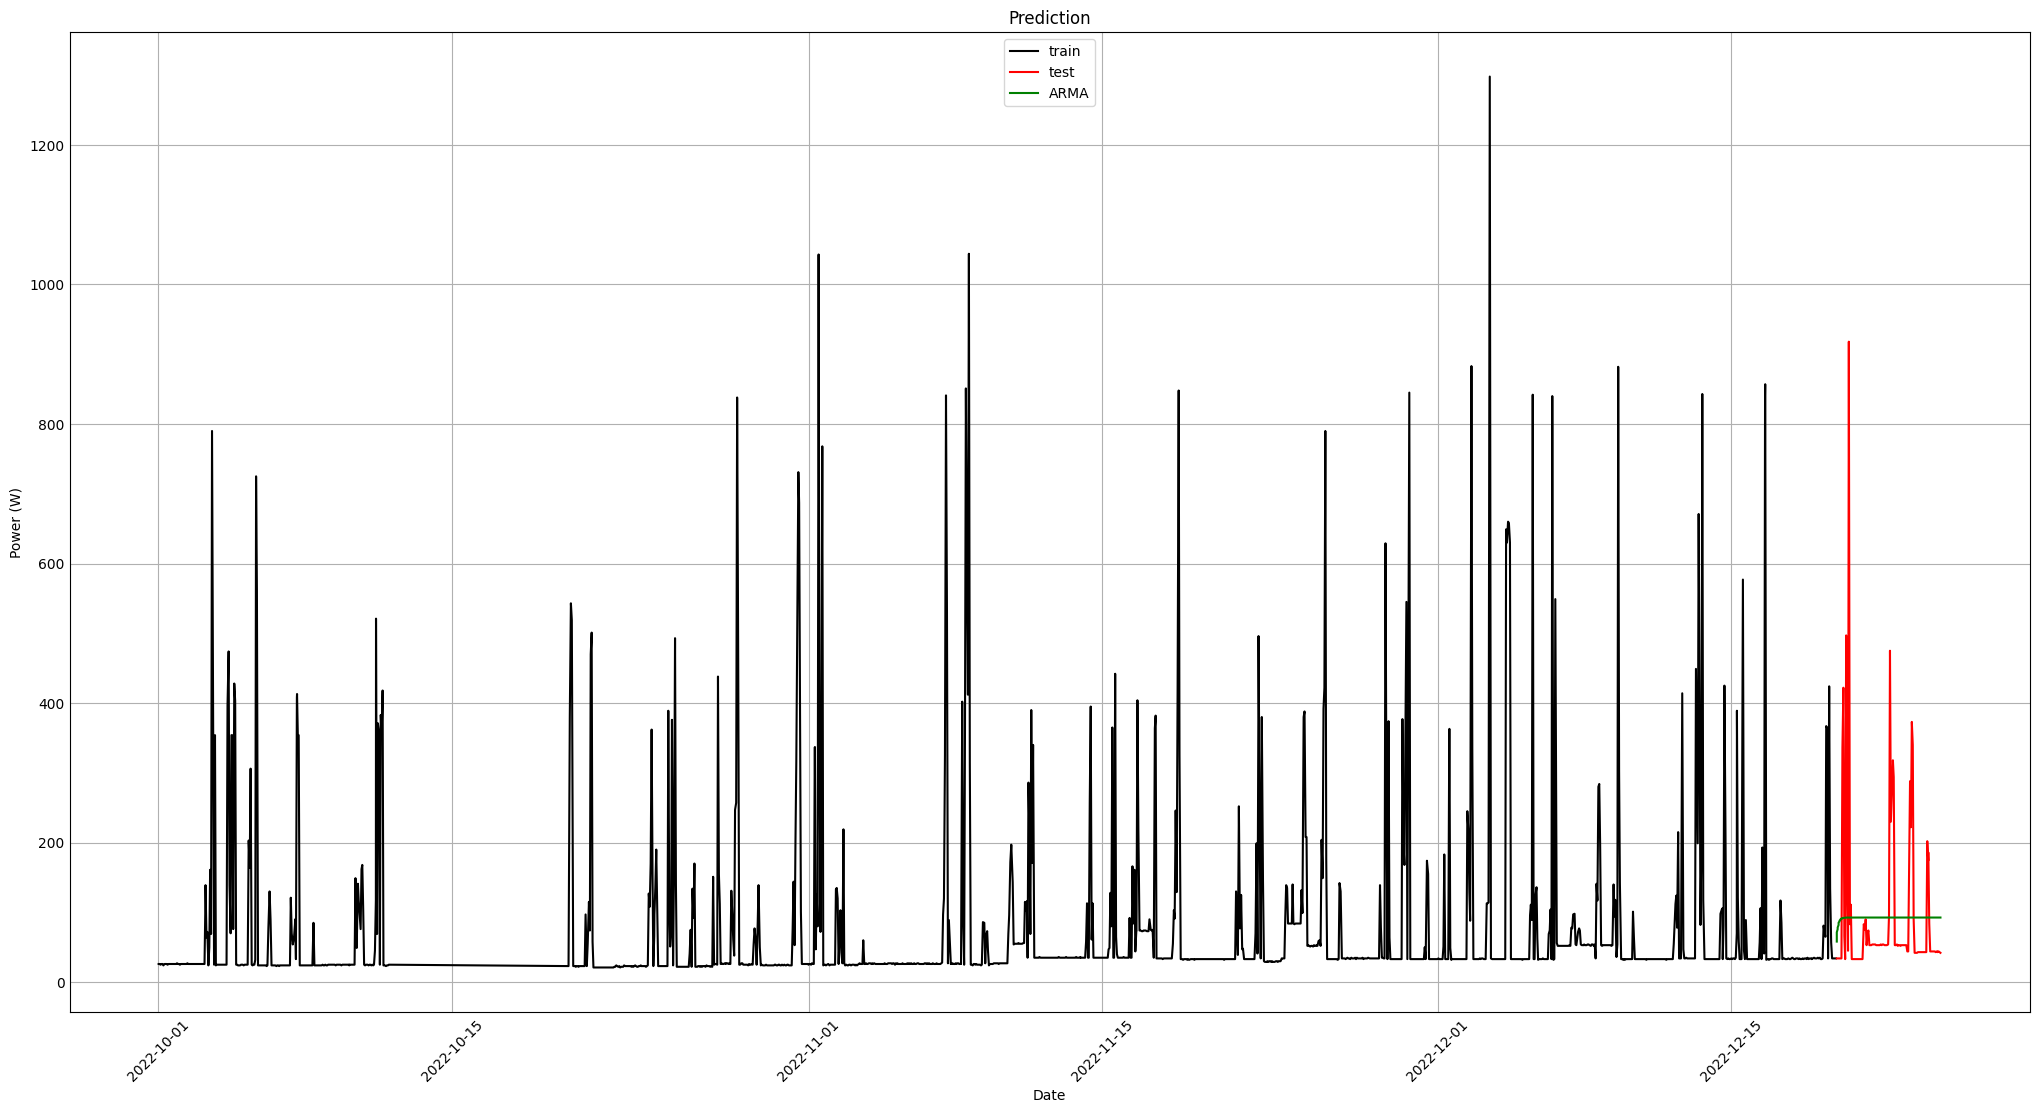

In [14]:
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
fig.set_dpi(100)
plt.title("Prediction")
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Power (W)')

plt.plot(train_x, train_df[data_colum_name], color = "black", label = "train")
plt.plot(test_x, test_df[data_colum_name], color = "red", label = "test")

plt.plot(arma_pred_out, color='green', label = 'ARMA')

plt.legend(loc='upper center')
plt.show()

In [15]:
arma_rmse = np.sqrt(mean_squared_error(test_df[data_colum_name].values, arma_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  123.98326827423607


In [16]:
arima_best_model, best_rmse = find_best_model(ARIMA, test_df)

(0, 0, 0) is better than (0, 0, 0) | 1000000 -> 124.16434158526457
(0, 0, 1) is better than (0, 0, 0) | 124.16434158526457 -> 124.12518115399939
(0, 0, 2) is better than (0, 0, 1) | 124.12518115399939 -> 124.11299840323173
(1, 0, 0) is better than (0, 0, 2) | 124.11299840323173 -> 124.00497409340791
(1, 0, 5) is better than (1, 0, 0) | 124.00497409340791 -> 123.98126968195011
(3, 0, 0) is better than (1, 0, 5) | 123.98126968195011 -> 123.97428277001487
Error! Continue


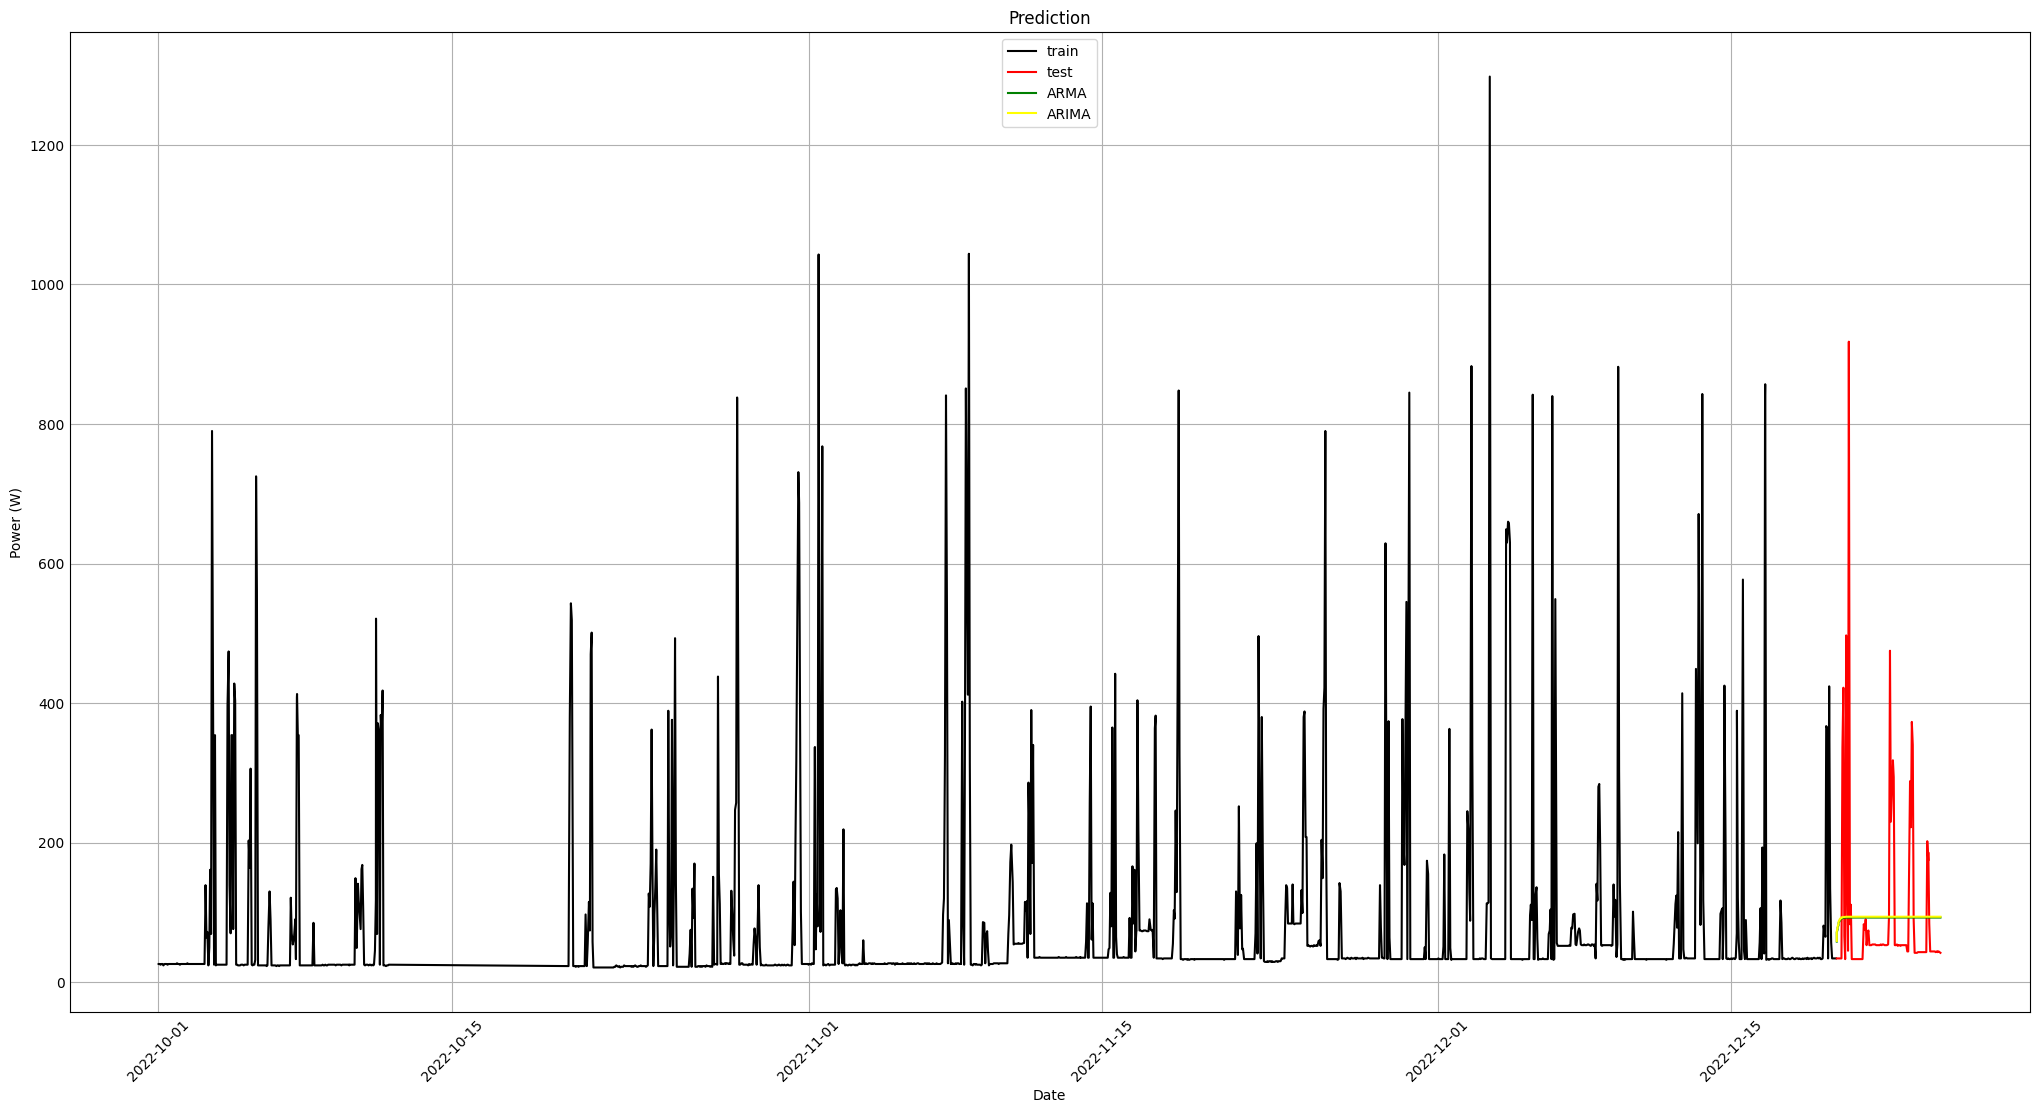

RMSE:  123.97428277001487


In [17]:
y = test_df[data_colum_name]

ARIMAmodel = ARIMA(y, order = arima_best_model)
ARIMAmodel = ARIMAmodel.fit()

arima_pred = ARIMAmodel.get_forecast(len(test_df.index))
arima_pred_df = arima_pred.conf_int(alpha = 0.05) 
arima_pred_df["Predictions"] = ARIMAmodel.predict(start = arima_pred_df.index[0], end = arima_pred_df.index[-1])
arima_pred_df.index = test_df["datetime"]
arima_pred_out = arima_pred_df["Predictions"] 

plt.style.use('_mpl-gallery')
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
fig.set_dpi(100)
plt.title("Prediction")
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Power (W)')

plt.plot(train_x, train_df[data_colum_name], color = "black", label = "train")
plt.plot(test_x, test_df[data_colum_name], color = "red", label = "test")

plt.plot(arma_pred_out, color='green', label = 'ARMA')
plt.plot(arima_pred_out, color='Yellow', label = 'ARIMA')

plt.legend(loc='upper center')
plt.show()

arma_rmse = np.sqrt(mean_squared_error(test_df[data_colum_name].values, arima_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

In [18]:
# columns = power_df.columns.difference(["datetime", "counter"])
resampled_power_df = power_df.resample('d', on='datetime').mean().dropna(how='all')
resampled_power_df["datetime"] = resampled_power_df.index
resampled_power_df

,counter,phase_a,phase_b,phase_c,total,datetime
datetime,,,,,,
2022-05-19,4101468.0,9.000000,10.000000,7.000000,26.000000,2022-05-19
2022-05-20,4101468.0,9.000000,29.909091,21.818182,60.727273,2022-05-20
2022-05-21,4101468.0,78.173913,16.000000,7.652174,101.826087,2022-05-21
2022-05-22,4101468.0,9.000000,8.000000,6.380952,23.380952,2022-05-22
2022-05-23,4101468.0,80.500000,162.400000,130.900000,373.800000,2022-05-23
...,...,...,...,...,...,...
2023-02-21,4101468.0,2.000000,0.000000,1.391304,3.391304,2023-02-21
2023-02-22,4101468.0,0.782609,0.000000,0.000000,0.782609,2023-02-22
2023-02-23,4101468.0,0.000000,0.000000,0.000000,0.000000,2023-02-23


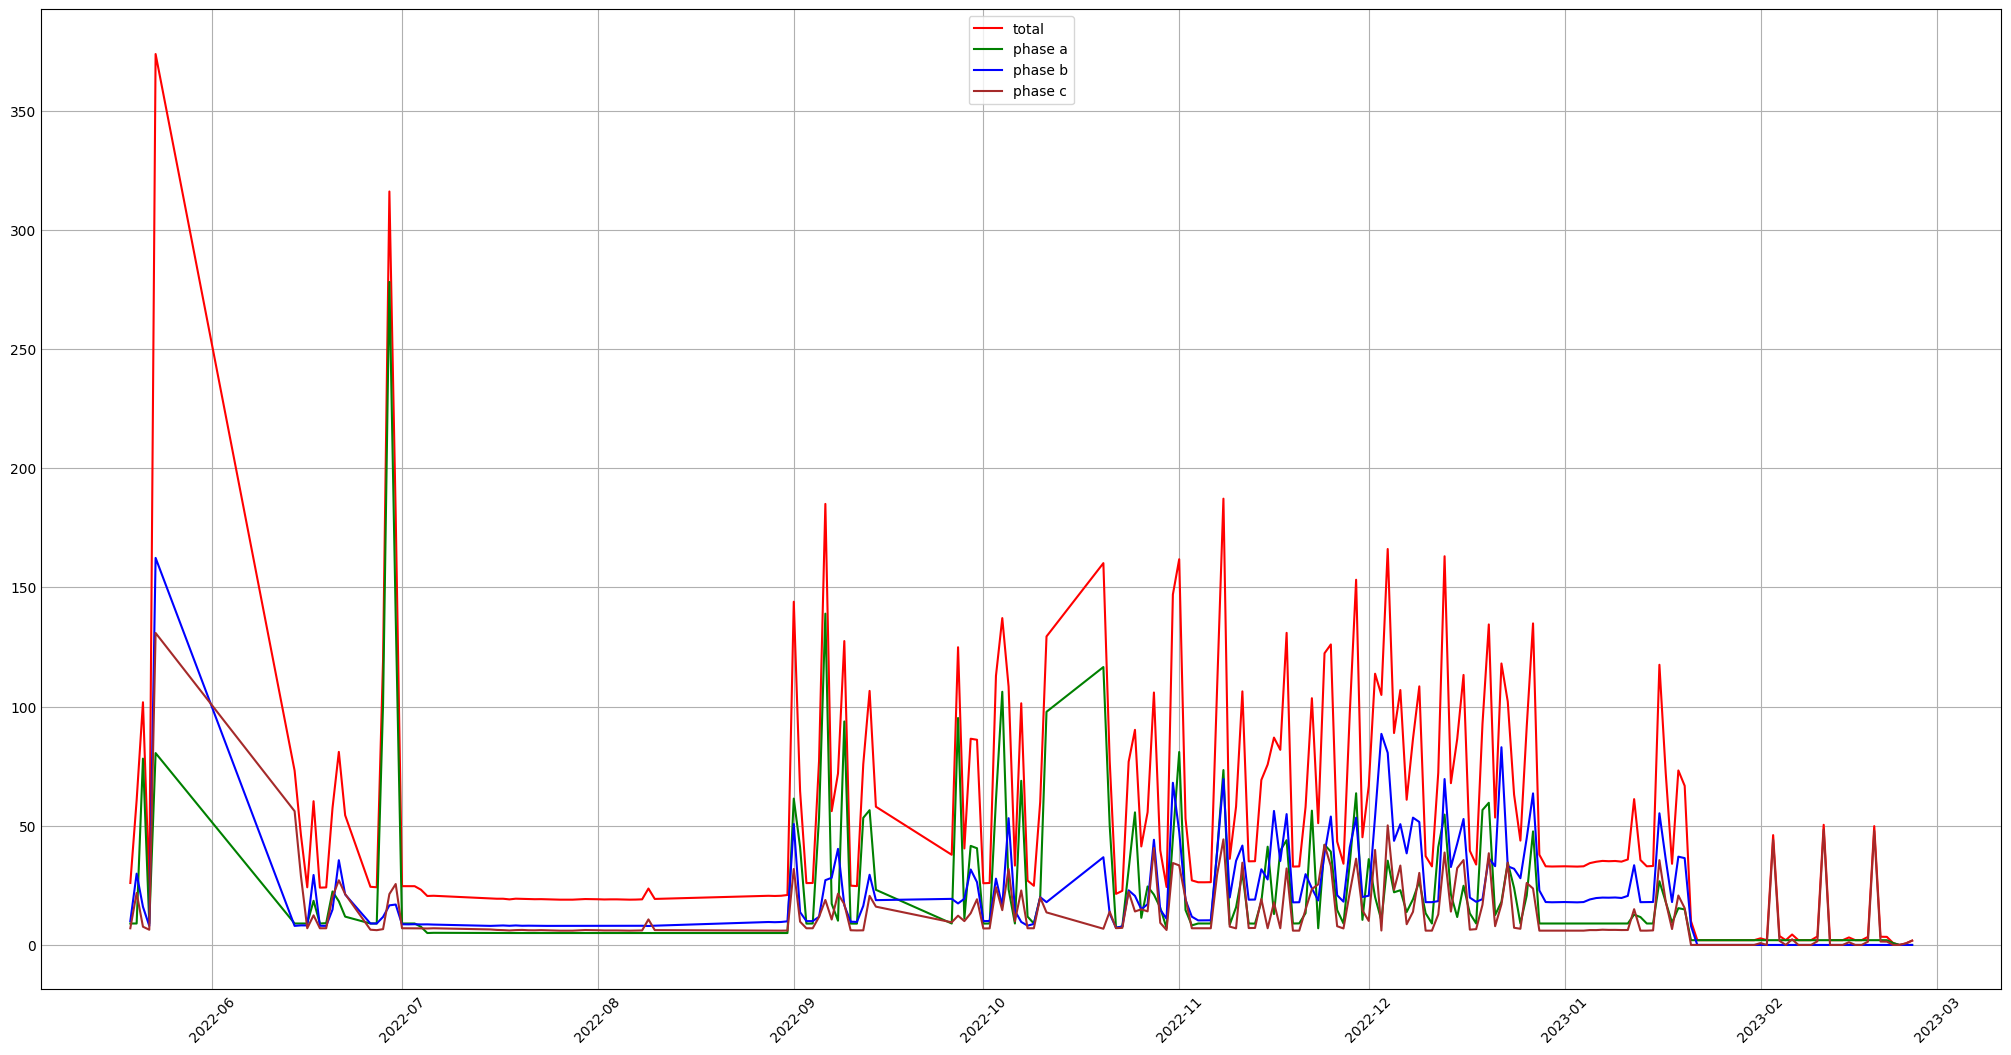

In [19]:
sample_resampled_power_df = resampled_power_df.loc[(resampled_power_df.index>=datetime.datetime(year=2022, month=12, day=1, hour=0)) & (resampled_power_df.index<=datetime.datetime(year=2023, month=2, day=2, hour=0))]
show_sample(resampled_power_df)

Давайте сравним графики

In [20]:
sample_from_datetime = datetime.datetime(year=2022, month=12, day=1, hour=0)
sample_to_datetime = datetime.datetime(year=2023, month=2, day=1, hour=0)

original_power_df = power_df.loc[(power_df.datetime>sample_from_datetime) & (power_df.datetime <= sample_to_datetime)]
avg_power_df = resampled_power_df.loc[(resampled_power_df.index>sample_from_datetime) & (resampled_power_df.index <= sample_to_datetime)]

raw_power_x = original_power_df.datetime
avg_power_x = avg_power_df.index


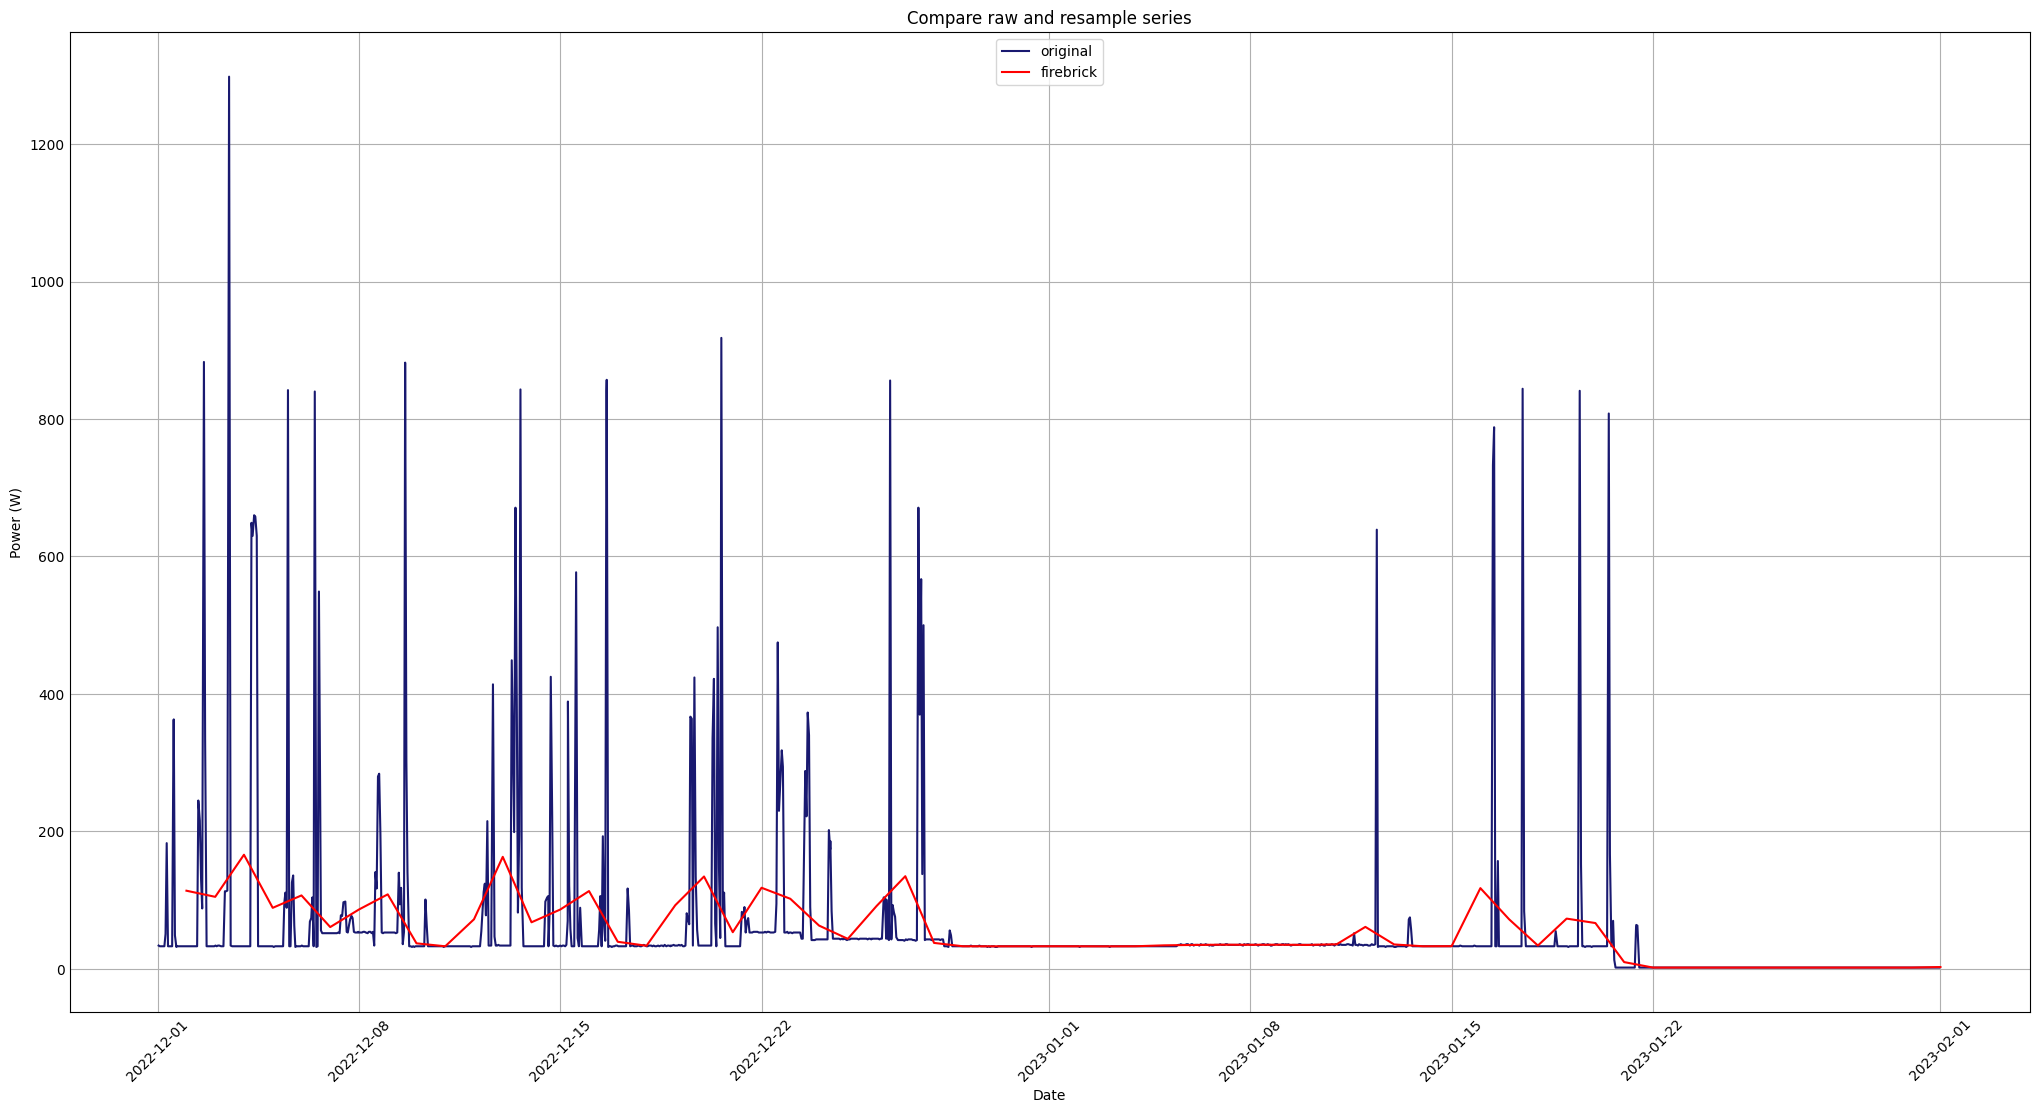

In [21]:
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
fig.set_dpi(100)
plt.title("Compare raw and resample series")
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Power (W)')

plt.plot(raw_power_x, original_power_df[data_colum_name], color = "midnightblue", label = "original")
plt.plot(avg_power_x, avg_power_df.total, color = "red", label = "firebrick")

plt.legend(loc='upper center')
plt.show()

Создадим набор тестовых и тренировачных данных

In [22]:
resampled_train_df = resampled_power_df.loc[(resampled_power_df.index>=from_datetime) & (resampled_power_df.index<=separation_datetime)]
resampled_test_df = resampled_power_df.loc[(resampled_power_df.index>separation_datetime) & (resampled_power_df.index <= to_datetime)]
print(len(resampled_train_df), len(resampled_test_df))

73 5


In [23]:
print("ARMA")
arma_best_model, arma_best_rmse = find_best_model(SARIMAX, resampled_test_df)
print("\nARIMA")
arima_best_model, arima_best_rmse = find_best_model(ARIMA, resampled_test_df)

ARMA
(0, 0, 0) is better than (0, 0, 0) | 1000000 -> 81.39146291617119
(0, 0, 1) is better than (0, 0, 0) | 81.39146291617119 -> 79.67775054960099
(0, 0, 2) is better than (0, 0, 1) | 79.67775054960099 -> 77.82996636828052
(0, 1, 0) is better than (0, 0, 2) | 77.82996636828052 -> 43.33194921872624
(0, 1, 2) is better than (0, 1, 0) | 43.33194921872624 -> 29.677751936237637
(0, 1, 4) is better than (0, 1, 2) | 29.677751936237637 -> 25.979596736713727
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue


d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\

Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
blah


d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-package

(2, 1, 0) is better than (0, 1, 4) | 25.979596736713727 -> 17.09108126005037
(2, 1, 1) is better than (2, 1, 0) | 17.09108126005037 -> 15.505316454093453
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
blah


d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-package

Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue


d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-package

Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue


d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-package

Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue


d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-package


ARIMA
(0, 0, 0) is better than (0, 0, 0) | 1000000 -> 28.864481192786748
(0, 0, 1) is better than (0, 0, 0) | 28.864481192786748 -> 28.806732057269418
(0, 0, 2) is better than (0, 0, 1) | 28.806732057269418 -> 24.625321404308206
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue


d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\

(1, 0, 2) is better than (0, 0, 2) | 24.625321404308206 -> 24.308334375236406
(1, 0, 5) is better than (1, 0, 2) | 24.308334375236406 -> 23.34357917436723
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
blah
(2, 0, 0) is better than (1, 0, 5) | 23.34357917436723 -> 18.651024290858327


d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-package

(2, 1, 0) is better than (2, 0, 0) | 18.651024290858327 -> 17.09108126005037
(2, 1, 1) is better than (2, 1, 0) | 17.09108126005037 -> 15.505316454093453
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
blah


d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-package

Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue


d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-package

Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue


d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-package

Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue


d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
d:\Documents\!мага\2 курс\Практика\3 семестр\Научная\power_prediction\env\lib\site-package

In [24]:
print("arima:", arima_best_rmse, "| arma:", arma_best_rmse)

arima: 15.505316454093453 | arma: 15.505316454093453


In [25]:
y = resampled_test_df[data_colum_name]

ARIMAmodel = ARIMA(y, order = arima_best_model)
ARIMAmodel = ARIMAmodel.fit()

arima_pred = ARIMAmodel.get_forecast(len(resampled_test_df.index))
arima_pred_df = arima_pred.conf_int(alpha = 0.05) 
arima_pred_df["Predictions"] = ARIMAmodel.predict(start = arima_pred_df.index[0], end = arima_pred_df.index[-1])
arima_pred_df.index = resampled_test_df["datetime"]
arima_pred_out = arima_pred_df["Predictions"] 


In [26]:
y = resampled_test_df[data_colum_name]

ARMAmodel = SARIMAX(y, order = arma_best_model)
ARMAmodel = ARMAmodel.fit()

arma_pred = ARMAmodel.get_forecast(len(resampled_test_df.index))
arma_pred_df = arma_pred.conf_int(alpha = 0.05) 
arma_pred_df["Predictions"] = ARMAmodel.predict(start = arma_pred_df.index[0], end = arma_pred_df.index[-1])
arma_pred_df.index = resampled_test_df["datetime"]
arma_pred_out = arma_pred_df["Predictions"] 

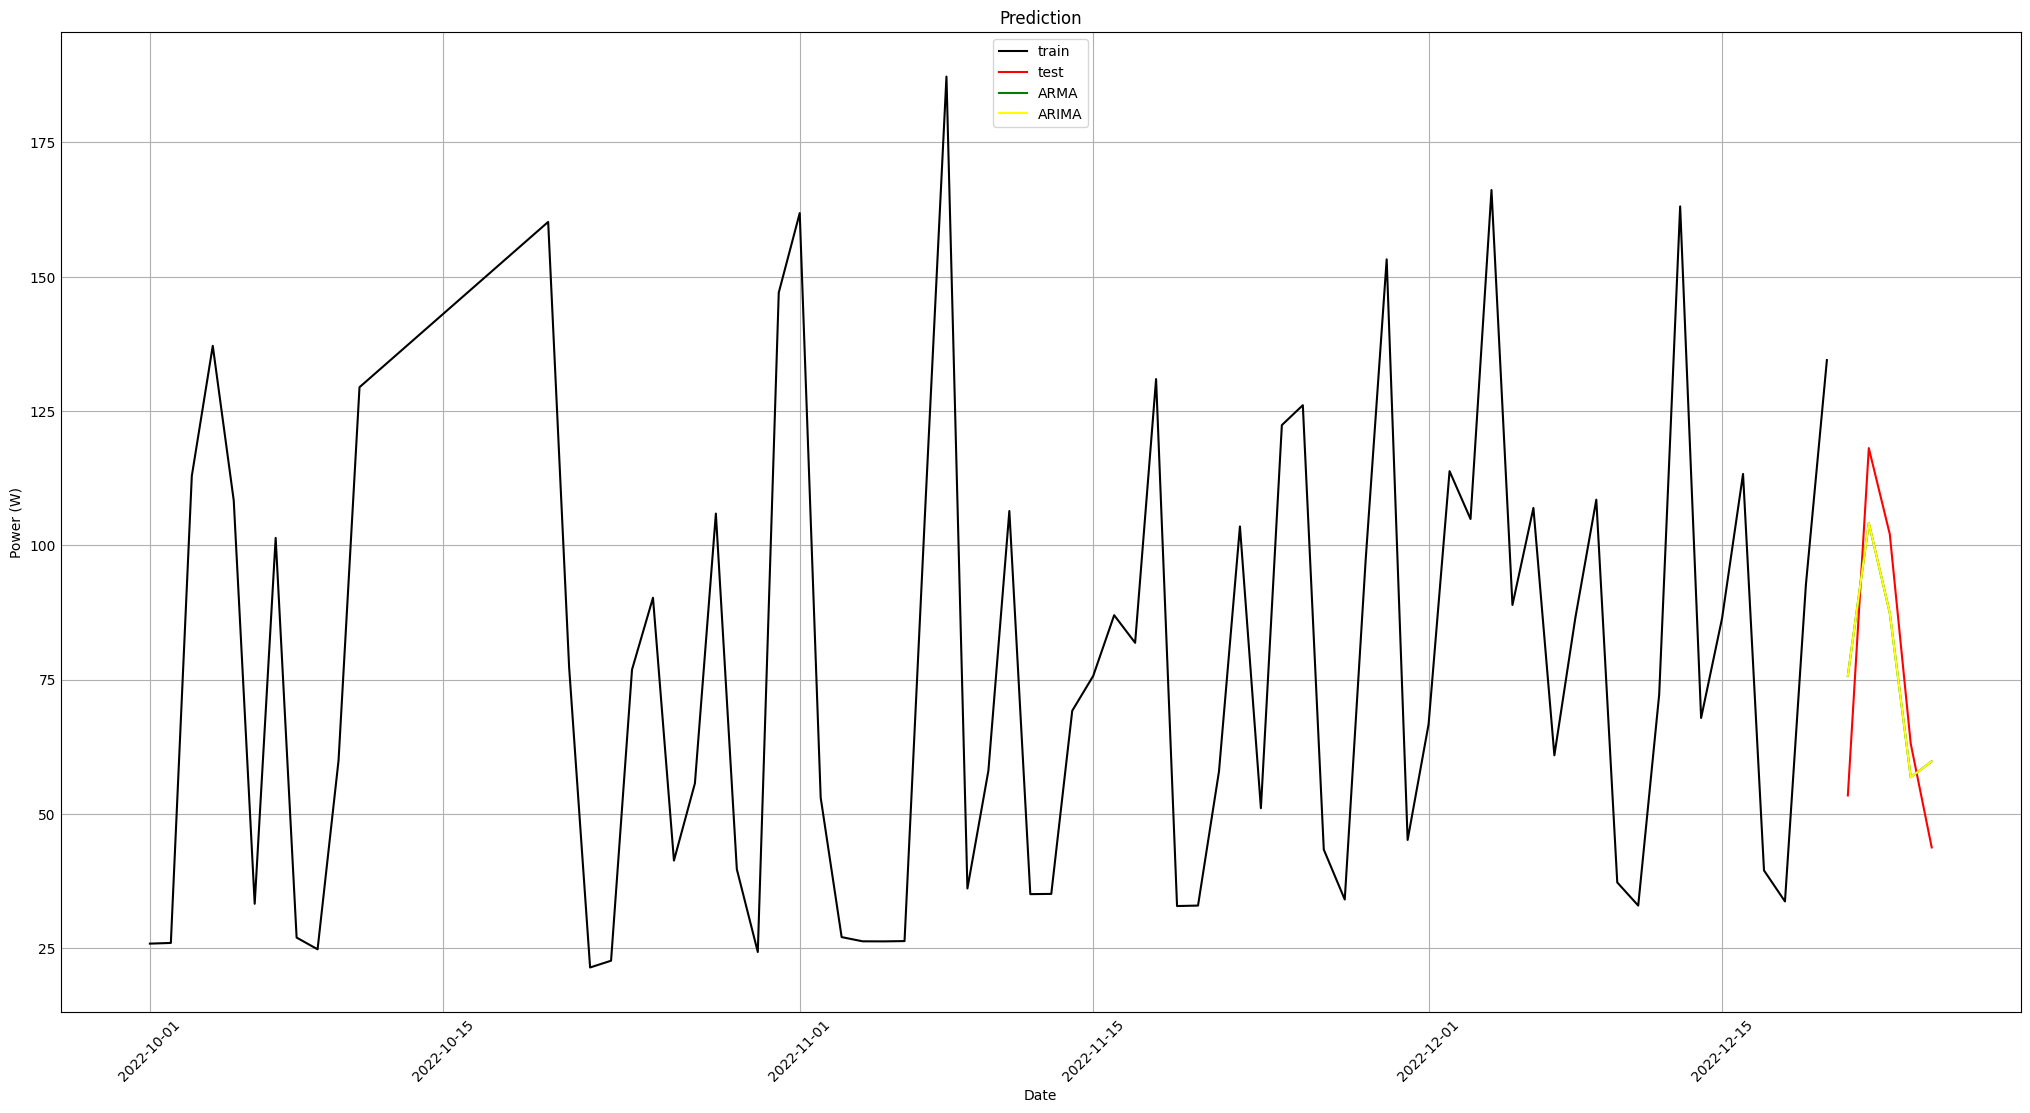

In [27]:
train_x = list(resampled_train_df.index)
test_x = list(resampled_test_df.index)

plt.style.use('_mpl-gallery')
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
fig.set_dpi(100)
plt.title("Prediction")
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Power (W)')

plt.plot(train_x, resampled_train_df[data_colum_name], color = "black", label = "train")
plt.plot(test_x, resampled_test_df[data_colum_name], color = "red", label = "test")

plt.plot(arma_pred_out, color='green', label = 'ARMA')
plt.plot(arima_pred_out, color='Yellow', label = 'ARIMA')

plt.legend(loc='upper center')
plt.show()